In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#TS Fresh Parameter Settings
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import extract_features

import matplotlib.patches as mpatches

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [2]:
## Helper function to return accuracy dataframe for each file
def return_acc_df(results_df):
    '''
    Input : Dataframe containing all raw results from hyperparameter tuning
    Output: Dataframe with accuracy per region for that classifier
    '''
    results_df = results_df.drop(columns = [col for col in results_df.columns if 'params' in col] +  [col for col in results_df.columns if 'results' in col] )
    res_df = run_expts.generate_subset_acc_std(results_df, return_df = True)
    acc_df = res_df[[col for col in res_df.columns if 'acc' in col]]
    mean_acc_df = pd.DataFrame( acc_df.mean(axis=0) ).T
    
    return mean_acc_df

#### Load files

In [3]:
# Ada_N1_Minimal_beta_expt2_5_fold_results_df.pkl
models = ['Ada' , 'DT', 'RF' , 'SVC']
expt_nums = ['1', '2']
# model + '_N1_Minimal_beta_expt' + expt_num + '_5_fold_results_df.pkl'

In [13]:
#Gives Training Score for a single model
model = 'Ada'
expt_num = '2'

folder = 'hyperparameter_tuning_results/expts_2/'
file_name = model + '_N1_Minimal_beta_expt' + expt_num + '_5_fold_results_df.pkl'

all_results_df = joblib.load(folder+file_name)

train_results_raw_df = all_results_df[['random_state'] + [ col for col in all_results_df.columns if 'train' in col]]
df = train_results_raw_df.copy()
df.rename(columns={'y_train': 'y_true'}, inplace=True)
df.columns = df.columns.str.replace('y_train_preds', 'y_preds')
return_acc_df(df)

,Prefrontal_Ada_acc,Frontal_Ada_acc,Left Frontal_Ada_acc,Right Frontal_Ada_acc
0,0.936771,0.931223,0.920555,0.928521


In [ ]:
### Pick the frontal region and look at which parameters were actually selected in CV 
# And what the validation score was for those parameters ... okayyy ? 

In [59]:
# Get the best params for each model man
best_params_dict = {}

region = 'Left Frontal' 
expt_num = '2'

for model in  ['Ada' , 'DT', 'RF' , 'SVC']:
    file_name = model + '_N1_Minimal_beta_expt' + expt_num + '_5_fold_results_df.pkl'
    all_results_df = joblib.load(folder+file_name)
    
    best_params = all_results_df[region + '_' + model + '_' + 'best_clf_params'].loc[0] + all_results_df[region + '_' + model + '_' + 'best_clf_params'].loc[1]
    best_params_dict[model + '_best_params'] = best_params

best_params_df = pd.DataFrame(best_params_dict)

In [57]:
pd.set_option('display.max_colwidth', None)

In [61]:
best_params_df

,Ada_best_params,DT_best_params,RF_best_params,SVC_best_params
0,"{'learning_rate': 0.05, 'n_estimators': 3}","{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2}","{'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 10}","{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}"
1,"{'learning_rate': 0.2, 'n_estimators': 2}","{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3}","{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 3}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}"
2,"{'learning_rate': 0.01, 'n_estimators': 2}","{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 2}","{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 1}","{'C': 1, 'gamma': 1, 'kernel': 'linear'}"
3,"{'learning_rate': 0.01, 'n_estimators': 2}","{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10}","{'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 3}","{'C': 1, 'gamma': 1, 'kernel': 'linear'}"
4,"{'learning_rate': 0.01, 'n_estimators': 3}","{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}","{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 3}","{'C': 1, 'gamma': 1, 'kernel': 'linear'}"
5,"{'learning_rate': 0.05, 'n_estimators': 2}","{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 2}","{'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 3}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}"
6,"{'learning_rate': 0.1, 'n_estimators': 2}","{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3}","{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 40}","{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}"
7,"{'learning_rate': 0.01, 'n_estimators': 10}","{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 5}","{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 1}","{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}"
8,"{'learning_rate': 0.1, 'n_estimators': 100}","{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3}","{'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'min_samples_split': 3, 'n_estimators': 3}","{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}"
9,"{'learning_rate': 0.01, 'n_estimators': 2}","{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3}","{'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 10}","{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}"


In [17]:
#Try to get validation score and parameters
all_results_df

best_parm

,random_state,y_true,Prefrontal_Ada_y_preds,y_train,Prefrontal_Ada_best_clf_params,Prefrontal_Ada_cv_results,Prefrontal_Ada_y_train_preds,Frontal_Ada_y_preds,Frontal_Ada_best_clf_params,Frontal_Ada_cv_results,Frontal_Ada_y_train_preds,Left Frontal_Ada_y_preds,Left Frontal_Ada_best_clf_params,Left Frontal_Ada_cv_results,Left Frontal_Ada_y_train_preds,Right Frontal_Ada_y_preds,Right Frontal_Ada_best_clf_params,Right Frontal_Ada_cv_results,Right Frontal_Ada_y_train_preds
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 1, 1, 1, ...","[[1, 0, 0, 1, 1, 0, 0, 0, 1, 0], [0, 1, 1, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'learning_rate': 2.0, 'n_estimators': 2}, {'...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...","[[1, 0, 1, 1, 1, 0, 0, 0, 1, 0], [0, 1, 1, 0, ...","[{'learning_rate': 0.4, 'n_estimators': 10}, {...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 1, 0, 0, 0, 1, 0], [0, 1, 1, 0, ...","[{'learning_rate': 0.05, 'n_estimators': 3}, {...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 0, 1, 1, 1, 1, 0, 0, 1, 0], [0, 1, 1, 1, ...","[{'learning_rate': 0.1, 'n_estimators': 50}, {...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, ...","[[0, 0, 0, 1, 0, 1, 1, 1, 0, 1], [0, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'learning_rate': 0.4, 'n_estimators': 40}, {...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 1, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, ...","[{'learning_rate': 1.0, 'n_estimators': 20}, {...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, ...","[{'learning_rate': 0.05, 'n_estimators': 2}, {...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 1, 0, 1, 1, 0, 0, 1], [0, 1, 1, 0, ...","[{'learning_rate': 10.0, 'n_estimators': 100},...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."


<Figure size 640x480 with 0 Axes>

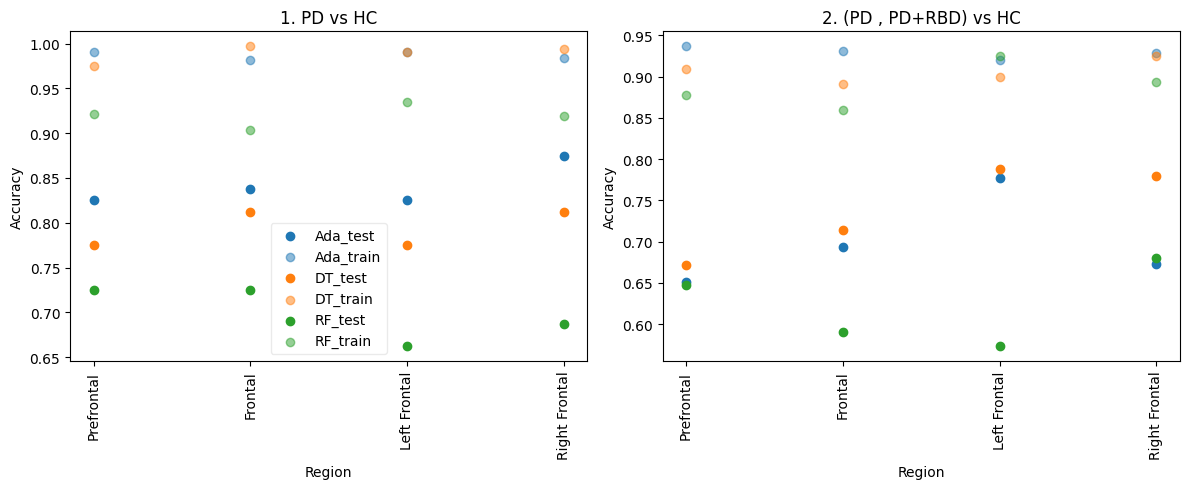

In [46]:
folder = 'hyperparameter_tuning_results/expts_2/'
fig = plt.figure()
fig = plt.figure(figsize=(12,5),dpi=100)
i=0

for expt_num in ['1', '2']:
    i+=1
    ax = fig.add_subplot(1,2,i)
   
    
    expt_info = [ '1. PD vs HC', '2. (PD , PD+RBD) vs HC', '3. (PD + PD&RBD) vs HC vs RBD', 
                 '4. PD vs PD+RBD vs RBD vs HC' ]
    plt.title(expt_info[int(expt_num)-1])
    
    colors = {'Ada':'tab:blue', 'DT':'tab:orange', 'RF':'tab:green', 'SVC':'tab:red'}
    
    # for label , model in zip(['_Ada_acc', '_DT_acc' , '_RF_acc' , '_SVC_acc'], ['Ada' , 'DT' , 'RF', 'SVC']):
    for label , model in zip(['_Ada_acc', '_DT_acc' , '_RF_acc'], ['Ada' , 'DT' , 'RF']):
        file_name = model + '_N1_Minimal_beta_expt' + expt_num + '_5_fold_results_df.pkl'
    
        all_results_df = joblib.load(folder+file_name)
        test_results_raw_df = all_results_df[['random_state' , 'y_true'] + [ col for col in all_results_df.columns if 'y_preds' in col]].copy()
        acc_df = return_acc_df(test_results_raw_df)
    
        train_results_raw_df = all_results_df[['random_state'] + [ col for col in all_results_df.columns if 'train' in col]].copy()
        train_results_raw_df.rename(columns={'y_train': 'y_true'}, inplace=True)
        train_results_raw_df.columns = train_results_raw_df.columns.str.replace('y_train_preds', 'y_preds')
        acc_train_df = return_acc_df(train_results_raw_df)
    
        plt.scatter([ val[:-len(label)] for val in acc_df.columns.values] , acc_df.values.ravel() , c = colors[model], label = model + '_test')
        plt.scatter([ val[:-len(label)] for val in acc_train_df.columns.values] , acc_train_df.values.ravel() , c = colors[model], alpha = 0.5, label = model + '_train')
        
        plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
        plt.xlabel('Region')
        plt.ylabel('Accuracy')
        
    #Only plot the legend for experiment 1
    if expt_num == '1':
        plt.legend(framealpha = 0.4)
    
    plt.tight_layout()
    plt.savefig('Test_and_train.png')

### BPW Only Features

In [64]:
'Ada_N2_bpw_only_Minimal_expt1_4_fold_results_df.pkl'
file_name = model + '_' + data_type + '_bpw_only_Minimal_expt1_4_fold_results_df.pkl'

NameError: name 'data_type' is not defined

In [62]:
folder = 'hyperparameter_tuning_results/expts_3/'
['N1','REM', 'N2', 'N3', 'Wake']

120

<Figure size 640x480 with 0 Axes>

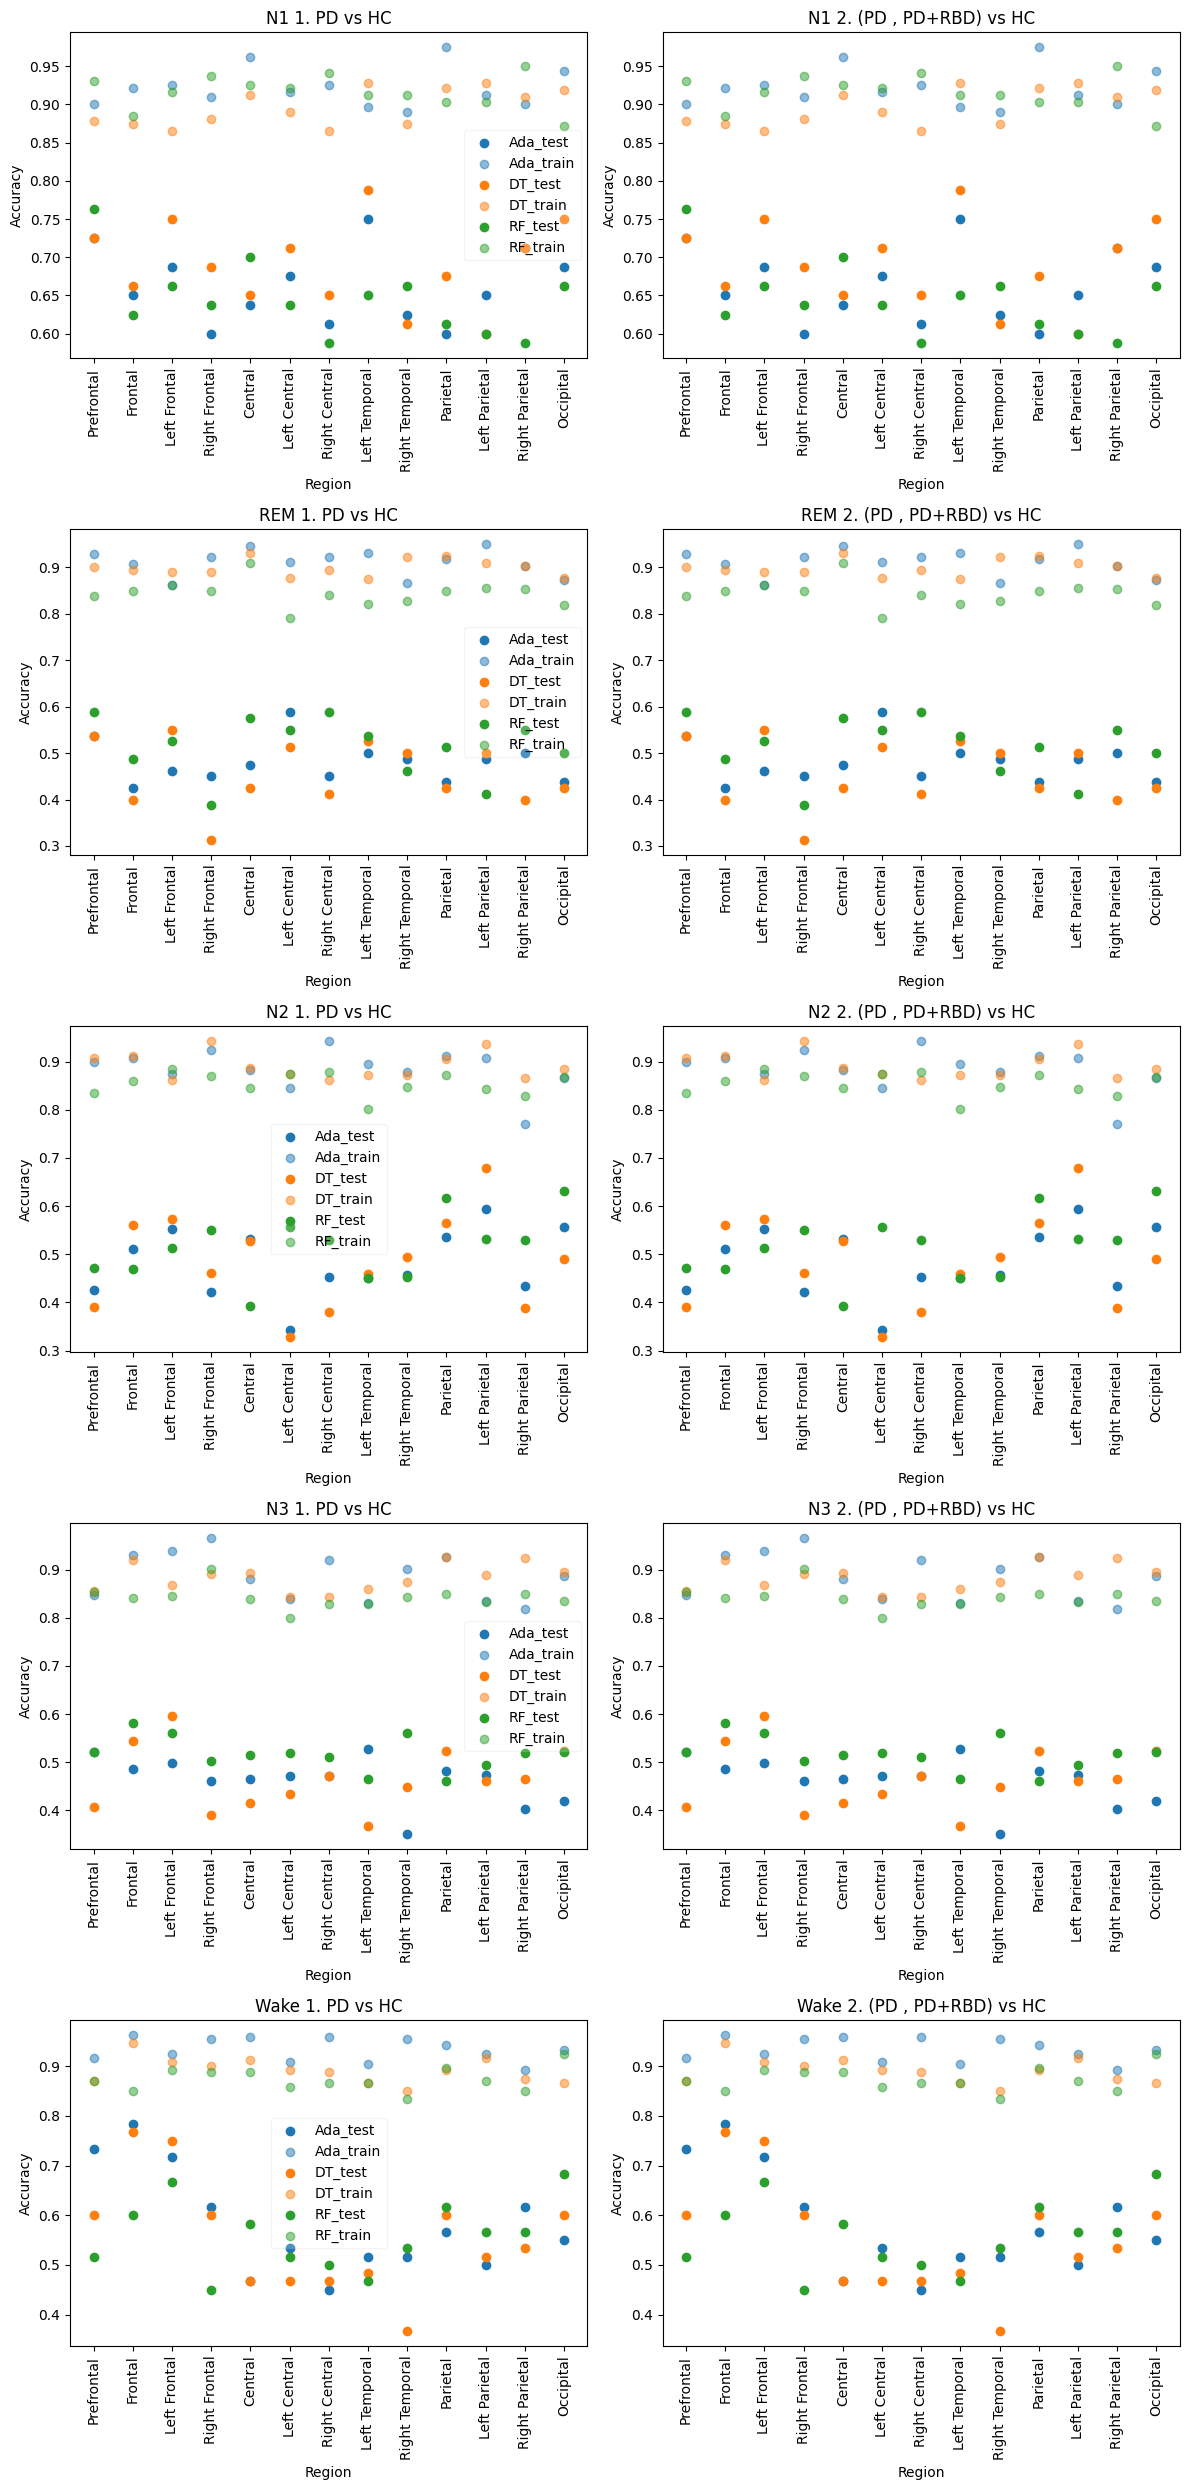

In [70]:
folder = 'hyperparameter_tuning_results/expts_3/'
data_type = 'N1'
fig = plt.figure()
fig = plt.figure(figsize=(12,25),dpi=100)
i=0


for data_type in ['N1','REM', 'N2', 'N3', 'Wake']:
    for expt_num in ['1', '2']:
        i+=1
        ax = fig.add_subplot(5,2,i)
       
        
        expt_info = [ '1. PD vs HC', '2. (PD , PD+RBD) vs HC', '3. (PD + PD&RBD) vs HC vs RBD', 
                     '4. PD vs PD+RBD vs RBD vs HC' ]
        
        plt.title(data_type + ' ' + expt_info[int(expt_num)-1])
        
        colors = {'Ada':'tab:blue', 'DT':'tab:orange', 'RF':'tab:green', 'SVC':'tab:red'}
        
        # for label , model in zip(['_Ada_acc', '_DT_acc' , '_RF_acc' , '_SVC_acc'], ['Ada' , 'DT' , 'RF', 'SVC']):
        for label , model in zip(['_Ada_acc', '_DT_acc' , '_RF_acc'], ['Ada' , 'DT' , 'RF']):
            file_name = model + '_' + data_type + '_bpw_only_Minimal_expt1_4_fold_results_df.pkl'
        
            all_results_df = joblib.load(folder+file_name)
            test_results_raw_df = all_results_df[['random_state' , 'y_true'] + [ col for col in all_results_df.columns if 'y_preds' in col]].copy()
            acc_df = return_acc_df(test_results_raw_df)
        
            train_results_raw_df = all_results_df[['random_state'] + [ col for col in all_results_df.columns if 'train' in col]].copy()
            train_results_raw_df.rename(columns={'y_train': 'y_true'}, inplace=True)
            train_results_raw_df.columns = train_results_raw_df.columns.str.replace('y_train_preds', 'y_preds')
            acc_train_df = return_acc_df(train_results_raw_df)
        
            plt.scatter([ val[:-len(label)] for val in acc_df.columns.values] , acc_df.values.ravel() , c = colors[model], label = model + '_test')
            plt.scatter([ val[:-len(label)] for val in acc_train_df.columns.values] , acc_train_df.values.ravel() , c = colors[model], alpha = 0.5, label = model + '_train')
            
            plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
            plt.xlabel('Region')
            plt.ylabel('Accuracy')
            
        #Only plot the legend for experiment 1
        if expt_num == '1':
            plt.legend(framealpha = 0.2)
        
        plt.tight_layout()
        plt.savefig('Test_and_train_bpw_minimal_only.png')